# [ PART 03. 통계분석 ] - 4장. 분산분석 (ANOVA)

## - 불러올 패키지 목록

In [1]:
# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

# 통계분석을 위해 사용하는 패키지
import scipy.stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd    # 사후검정 시 사용
from statsmodels.sandbox.stats.multicomp import MultiComparison    # MultiComparison을 활용한 사후검정 시 사용
from statsmodels.graphics.factorplots import interaction_plot    # 상호작용효과 그래프 출력 시 사용
import pingouin as pg    # 분산분석 시 사용, 패키지 설치는 pip install pingouin 실행
import scikit_posthocs as sp    # 사후검정 시 사용, 패키지 설치는 pip install scikit-posthocs


# 시각화를 위한 패키지
from matplotlib import pyplot as plt
import seaborn as sns

# %matplotlib inline 의 목적은 plt.show()함수가 호출되지 않은 경우에도 matplotlib 다이어그램을 렌더링하는 것이다.
# 그러나 현재 업데이트된 버전의 주피터 노트북 버전에서는 %matplotlib inline 를 사용하지 않더라도 Matplotlib 다이어그램을 개체로 표현한다.
# 따라서 굳이 필요하지는 않다. 그러나 코드를 깨끗하게 유지하고 자신이 만든 플롯을 호출하기 위해 여전히 관례적으로 권장된다.
%matplotlib inline

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

## 1. 일원배치 분산분석

In [2]:
df_iris = pd.read_csv( r'C:\Users\Boanerges\GitHub\rawdata\iris.csv',
                         index_col = 'Unnamed: 0' )

In [3]:
# 컬럼이름에 섞여있는 '.' 을 '_' 로 변경
# statsmodels 패키지를 사용하여 일원분산 분석 실시할 때 오류 발생 방지

df_iris.rename( columns = {'Sepal.Length':'Sepal_Length',
                           'Sepal.Width':'Sepal_Width',
                           'Petal.Length':'Petal_Length',
                           'Petal.Width':'Petal_Width'},
                inplace = True )

df_iris

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,virginica
147,6.3,2.5,5.0,1.9,virginica
148,6.5,3.0,5.2,2.0,virginica
149,6.2,3.4,5.4,2.3,virginica


### 1.1. 등분산 검정

< 가설 설정 - 등분산성 검정 >
- 귀무가설(H0) : 두 집단의 분산이 동일하다.
- 대립가설(H1) : 두 집단의 분산이 동일하지 않다.

< 유의수준은 0.05 로 설정 >

In [4]:
df_one_anova = pd.DataFrame( df_iris,
                             columns = ['Sepal_Width', 'Species'] )

type1 = df_one_anova[ df_iris['Species'] == 'setosa' ]['Sepal_Width']
type2 = df_one_anova[ df_iris['Species'] == 'versicolor' ]['Sepal_Width']
type3 = df_one_anova[ df_iris['Species'] == 'virginica' ]['Sepal_Width']

#### 1.1.1. Bartlett's test

In [5]:
# scipy.stats.bartlett( sample1, sample2,… )

bartlett_test = stats.bartlett( type1, type2, type3 )

print( f" Statistic(Bartlett's test): {bartlett_test[0]:.3f} \n P-value: {bartlett_test[1]:.12f} " )

if bartlett_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if bartlett_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Bartlett's test): 2.091 
 P-value: 0.351502800416 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



#### 1.1.2. Levene's test

In [6]:
# scipy.stats.levene( sample1, sample2,…,
#                     center = 'median',    # 검정에 사용할 통계값의 종류. 'mean’, ‘median’, ‘trimmed’
#                                           # 기본값은 ‘median’.
#                     proportiontocut = 0.05 )    # center 옵션에 ‘trimmed’ 을 지정할 경우. 데이터의 각 끝으로부터 잘라내는 지점의 비율을 지정.
#                                                 # 기본값은 0.05.

# 등분산 검정 레빈(levene)

levene_test = stats.levene( type1, type2, type3 )

print( f" Statistic(Levene's Test): {levene_test[0]:.3f} \n P-value: {levene_test[1]:.12f} " )

if levene_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if levene_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Levene's Test): 0.590 
 P-value: 0.555517898474 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



In [7]:
# 분산의 동질성 검정 기준을 기본값 'median'이 아닌 'mean' 으로 변경할 경우

levene_test2 = stats.levene( type1, type2, type3,
                            center = 'mean' )

print( f" Statistic(Levene's Test): {levene_test[0]:.3f} \n P-value: {levene_test[1]:.12f} " )

if levene_test2[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if levene_test2[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Levene's Test): 0.590 
 P-value: 0.555517898474 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



#### 1.1.3. Fligner’s test

In [8]:
# scipy.stats.fligner( sample1, sample2,…,
#                      center = 'median',    # 검정에 사용할 통계값의 종류. 'mean’, ‘median’, ‘trimmed’
#                                            # 기본값은 ‘median’.
#                      proportiontocut = 0.05 )    # center 옵션에 ‘trimmed’ 을 지정할 경우. 데이터의 각 끝으로부터 잘라내는 지점의 비율을 지정.
#                                                  # 기본값은 0.05.

fligner_test = stats.fligner( type1, type2, type3 )

print( f" Statistic(Fligner’s Test): {fligner_test[0]:.3f} \n P-value: {fligner_test[1]:.12f} " )

if fligner_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if fligner_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Fligner’s Test): 0.912 
 P-value: 0.633750652353 
 p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.



### 1.2. one-way ANOVA
< 가설 설정 - ANOVA >
- 귀무가설(H0) : 세 가지 종의 Sepal.Width의 평균은 같다.
- 대립가설(H1) : 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.

< 유의수준은 0.05 로 설정 >

#### 1.2.1. pingouin 패키지 사용

In [9]:
# pingouin.anova( data = None,    # 데이터프레임
#                 dv = None,    # 종속 변수를 포함하는 데이터의 열 이름
#                 between = None,    # 개체 간 요인을 포함하는 데이터의 열 이름
#                                    # 단일 문자열이면 one-way ANOVA 수행.
#                                    # 두 개 이상의 요소를 포함하는 목록이면 N-way ANOVA 수행
#                 ss_type = 2,    # 요인이 2개 이상인 불균형 설계에 대해 제곱합을 계산하는 방법을 지정
#                 detailed = False,    # True인 경우 자세한 ANOVA 테이블을 반환
#                                      # 기본값은 one-way ANOVA 인 경우는 False, N-way ANOVA 인 경우는 True. 
#                 effsize = 'np2' )    # 효과 크기. 'np2'(부분 에타 제곱) 또는 'n2'(에타 제곱)여야 한다.
#                                      # 일원 분산 분석의 경우 부분 에타 제곱은 에타 제곱과 동일

results = pg.anova( data = df_iris,
                    dv = 'Sepal_Width', between = 'Species',
                    detailed = True )

print(results)

    Source         SS   DF        MS         F         p-unc       np2
0  Species  11.344933    2  5.672467  49.16004  4.492017e-17  0.400783
1   Within  16.962000  147  0.115388       NaN           NaN       NaN


#### 1.2.2. statsmodels 패키지 사용

In [10]:
df_one_anova

,Sepal_Width,Species
1,3.5,setosa
2,3.0,setosa
3,3.2,setosa
4,3.1,setosa
5,3.6,setosa
...,...,...
146,3.0,virginica
147,2.5,virginica
148,3.0,virginica
149,3.4,virginica


In [11]:
# statsmodels 패키지를 사용하여 일원분산 분석 실시

df_one_anova = pd.DataFrame( df_iris,
                             columns = ['Sepal_Width', 'Species'] )

results = ols( 'Sepal_Width ~ C(Species)', data = df_one_anova ).fit()

print(results.summary())
print()

                            OLS Regression Results                            
Dep. Variable:            Sepal_Width   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     49.16
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           4.49e-17
Time:                        19:17:43   Log-Likelihood:                -49.366
No. Observations:                 150   AIC:                             104.7
Df Residuals:                     147   BIC:                             113.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### 1.2.3. scipy.stats 패키지 사용

In [12]:
# scipy.stats 패키지를 사용하여 일원분산 분석 실시

# scipy.stats.f_oneway( sample1, sample2, …,
#                       axis = 0 )    # 테스트가 적용되는 입력 배열의 축. 기본값은 0

one_anova_result = stats.f_oneway(type1, type2, type3)

print( f' F-Value: {one_anova_result[0]:.4f}    P-value: {one_anova_result[1]:.28f}' )

if one_anova_result[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설을 채택. \n 세 가지 종의 Sepal.Width의 평균은 같다.")
if one_anova_result[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설을 기각. \n 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.")
print()

 F-Value: 49.1600    P-value: 0.0000000000000000449201713331
 p-value < 0.05 이므로 귀무가설을 기각. 
 적어도 하나 이상의 종에 대한 Sepal.Width의 평균값에는 차이가 있다.



### 1.3. 사후 검정

#### 1.3.1. Tukey's HSD (Honest Significant Difference) test

##### 1.3.1.1. statsmodels 패키지의 pairwise_tukeyhsd() 패키지 활용

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
    setosa versicolor   -0.658  0.001 -0.8189 -0.4971   True
    setosa  virginica   -0.454  0.001 -0.6149 -0.2931   True
versicolor  virginica    0.204 0.0088  0.0431  0.3649   True
------------------------------------------------------------



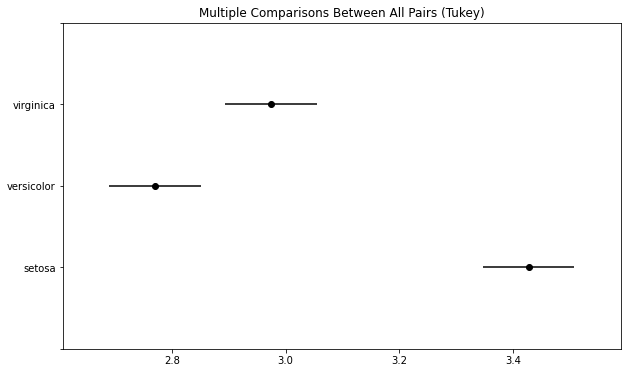

In [13]:
# pairwise_tukeyhsd( endog,    # 응답 변수. 1차원 배열
#                    group,    # 그룹. 1차원 배열
#                    alpha = 0.05 )    # 유의수준 설정. 기본값은 0.05.

posthoc = pairwise_tukeyhsd( df_iris['Sepal_Width'], df_iris['Species'],
                             alpha=0.05)
print(posthoc)
print()
fig = posthoc.plot_simultaneous()

##### 1.3.1.2. scikit_posthocs 패키지의 posthoc_tukey_hsd() 활용

In [14]:
# pairwise_tukeyhsd( x,    # 종속 변수 값(테스트 또는 응답 변수)을 포함하는 배열 및 배열 인터페이스를 노출하는 모든 객체.
#                          # 값은 비명목 척도를 가져야 한다.
#                    g,    # 독립 변수 값(그룹화 또는 예측 변수)을 포함하는 배열 및 배열 인터페이스를 노출하는 모든 개체.
#                          # 값은 범주형(명목척도)이어야 한다.
#                    alpha = 0.05 )    # 유의수준 설정. 기본값은 0.05.

posthoc = sp.posthoc_tukey_hsd( df_iris['Sepal_Width'],
                                df_iris['Species'],
                                alpha = 0.05)
print(posthoc)
print()

            setosa  versicolor  virginica
setosa           1           1          1
versicolor       1           1          1
virginica        1           1          1



In [15]:
posthoc = sp.posthoc_tukey(  df_iris,
                             val_col = 'Sepal_Width',
                             group_col = 'Species',
                             sort = False )
print(posthoc)
print()

            setosa  versicolor  virginica
setosa       1.000    0.001000   0.001000
versicolor   0.001    1.000000   0.008779
virginica    0.001    0.008779   1.000000



#### 1.3.2. Scheffé’s Method

##### 1.3.2.1. scikit_posthocs 패키지의 posthoc_scheffe() 활용

In [16]:
# posthocs.posthoc_scheffe( a,    # array_like 또는 pandas DataFrame 객체
#                           val_col = None,    # 종속 변수 값(테스트 또는 응답 변수)을 포함하는 DataFrame 열의 이름. 값은 비명목 척도를 가져야 한다.
#                           group_col = None,  # 독립 변수 값(그룹화 또는 예측 변수)을 포함하는 DataFrame 열의 이름. 값은 범주형이어야 한다.
#                           sort = False,    # 기본값은 False. True 로 지정할 경우 블록별로 데이터를 정렬하고 열을 그룹화한다.
#                           p_adjust = None )    # p 값을 조정하는 방법. 기본값은 None.
#                                                # ‘bonferroni’ : one-step correction
#                                                # ‘sidak’ : one-step correction
#                                                # ‘holm-sidak’ : step-down method using Sidak adjustments
#                                                # ‘holm’ : step-down method using Bonferroni adjustments
#                                                # ‘simes-hochberg’ : stepup method (independent)
#                                                # ‘hommel’ : closed method based on Simes tests (non-negative)
#                                                # ‘fdr_bh’ : Benjamini/Hochberg (non-negative)
#                                                # ‘fdr_by’ : Benjamini/Yekutieli (negative)
#                                                # ‘fdr_tsbh’ : two stage fdr correction (non-negative)
#                                                # ‘fdr_tsbky’ : two stage fdr correction (non-negative)

sp.posthoc_scheffe( df_iris,
                    val_col = 'Sepal_Width',
                    group_col = 'Species',
                    sort = False )

,setosa,versicolor,virginica
setosa,1.000000e+00,1.758878e-16,3.405790e-09
versicolor,1.758878e-16,1.000000e+00,1.258285e-02
virginica,3.405790e-09,1.258285e-02,1.000000e+00


#### 1.3.3. Pairwise T-test

##### 1.3.3.1. scikit_posthocs 패키지의 posthoc_ttest() 활용

In [17]:
# posthoc_ttest( a,    # # array_like 또는 pandas DataFrame 객체
#                val_col = None,    # 종속 변수 값(테스트 또는 응답 변수)을 포함하는 DataFrame 열의 이름. 값은 비명목 척도를 가져야 한다.
#                group_col = None,    # 독립 변수 값(그룹화 또는 예측 변수)을 포함하는 DataFrame 열의 이름. 값은 범주형이어야 한다.
#                pool_sd = False,    # 기본값은 False. 모든 그룹에 대한 공통 SD를 계산하여 모든 비교에 사용(일부 그룹이 작은 경우 유용할 수 있음)
#                equal_var = True,    # True(기본값)인 경우 동일한 모집단 분산1을 가정하는 표준 독립 검정을 수행.
#                                     #False이면 동일한 모집단 분산을 가정하지 않는 Welch의 t-검정을 수행
#                sort = False,    # group_col을 기준으로 DataFrame을 정렬할지 여부를 지정. 기본값은 False.
#                p_adjust = None )    # p 값을 조정하는 방법. 기본값은 None.
#                                     # ‘bonferroni’ : one-step correction
#                                     # ‘sidak’ : one-step correction
#                                     # ‘holm-sidak’ : step-down method using Sidak adjustments
#                                     # ‘holm’ : step-down method using Bonferroni adjustments
#                                     # ‘simes-hochberg’ : stepup method (independent)
#                                     # ‘hommel’ : closed method based on Simes tests (non-negative)
#                                     # ‘fdr_bh’ : Benjamini/Hochberg (non-negative)
#                                     # ‘fdr_by’ : Benjamini/Yekutieli (negative)
#                                     # ‘fdr_tsbh’ : two stage fdr correction (non-negative)
#                                     # ‘fdr_tsbky’ : two stage fdr correction (non-negative)

sp.posthoc_ttest( df_iris,
                    val_col = 'Sepal_Width',
                    group_col = 'Species',
                    sort = False )

,setosa,versicolor,virginica
setosa,1.000000e+00,1.845260e-15,4.246355e-09
versicolor,1.845260e-15,1.000000e+00,1.819100e-03
virginica,4.246355e-09,1.819100e-03,1.000000e+00


##### 1.3.3.2. statsmodels의 MultiComparison 패키지 및 allpairtest() 활용

In [18]:
comp = MultiComparison( df_one_anova['Sepal_Width'], df_one_anova['Species'] )

# Bonferroni 방법을 통해 모든 그룹간 ttest를 진행
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
setosa,versicolor,9.455,0.0,0.0,True
setosa,virginica,6.4503,0.0,0.0,True
versicolor,virginica,-3.2058,0.0018,0.0055,True


## 2. 이원배치 분산분석

In [19]:
# 데이터프레임 생성

df_mtcars = pd.read_csv(r'C:\Users\Boanerges\GitHub\rawdata\mtcars.csv')
df_mtcars

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


### 2.1. 등분산 검정
< 가설 설정 - 등분산성 검정 >
- 귀무가설(H0) : 세 집단의 분산이 동일하다.
- 대립가설(H1) : 적어도 한 집단의 분산이 동일하지 않다.

< 유의수준은 0.05 로 설정 >

#### 1.1.1. Bartlett's test

In [20]:
# stats.bartlett( sample1, sample2,… )

bartlett_test = stats.bartlett( df_mtcars['am'], df_mtcars['cyl'], df_mtcars['mpg'] )

print( f" Statistic(Bartlett's test): {bartlett_test[0]:.3f} \n P-value: {bartlett_test[1]:.12f} " )

if bartlett_test[1] < 0.05:
    print(" p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.")
if bartlett_test[1] > 0.05:
    print(" p-value > 0.05 이므로 귀무가설 채택. 등분산성을 만족한다.")
print()

 Statistic(Bartlett's test): 134.195 
 P-value: 0.000000000000 
 p-value < 0.05 이므로 귀무가설 기각. 등분산성을 만족하지 않는다.



### 2.2. two-way ANOVA

< 가설 설정 - ANOVA >

1. 주효과 검정에 대한 가설  
a. 귀무가설(H0) : 실린더 개수에 따른 주행거리 차이는 존재하지 않는다.  
a. 대립가설(H1) : 실린더 개수에 따른 주행거리 차이가 존재한다.  
b. 귀무가설(H0) : 변속기 종류에 따른 주행거리 차이는 존재하지 않는다.  
b. 대립가설(H1) : 변속기 종류에 따른 주행거리 차이가 존재한다.

2) 상호작용효과 검정에 대한 가설
- 귀무가설(H0) : 변속기 종류와 실린더 개수 간에는 상호작용 효과가 없다.
- 대립가설(H1) : 변속기 종류와 실린더 개수 간에는 상호작용 효과가 있다.

< 유의수준은 0.05 로 설정 >

#### 2.2.1. pingouin 패키지 사용

In [21]:
# pingouin.anova( data = None,    # 데이터프레임
#                 dv = None,    # 종속 변수를 포함하는 데이터의 열 이름
#                 between = None,    # 개체 간 요인을 포함하는 데이터의 열 이름
#                                    # 단일 문자열이면 one-way ANOVA 수행.
#                                    # 두 개 이상의 요소를 포함하는 목록이면 N-way ANOVA 수행
#                 ss_type = 2,    # 요인이 2개 이상인 불균형 설계에 대해 제곱합을 계산하는 방법을 지정
#                 detailed = False,    # True인 경우 자세한 ANOVA 테이블을 반환
#                                      # 기본값은 one-way ANOVA 인 경우는 False, N-way ANOVA 인 경우는 True. 
#                 effsize = 'np2' )    # 효과 크기. 'np2'(부분 에타 제곱) 또는 'n2'(에타 제곱)여야 한다.
#                                      # 일원 분산 분석의 경우 부분 에타 제곱은 에타 제곱과 동일

results = pg.anova( data = df_mtcars,
                    dv = 'mpg', between = ['am','cyl'] )

print(results)

     Source          SS    DF          MS          F         p-unc       np2
0        am   36.766919   1.0   36.766919   3.998759  5.608373e-02  0.133297
1       cyl  456.400921   2.0  228.200461  24.819011  9.354735e-07  0.656258
2  am * cyl   25.436511   2.0   12.718256   1.383233  2.686140e-01  0.096170
3  Residual  239.059167  26.0    9.194583        NaN           NaN       NaN


#### 2.2.2. statsmodels 패키지 사용

In [22]:
# statsmodels 패키지
from statsmodels.api import *
from statsmodels.formula.api import *
from statsmodels.stats.api import *
from statsmodels.stats.proportion import *
from statsmodels.stats.diagnostic import *
from statsmodels.stats.weightstats import *
from statsmodels.stats.outliers_influence import *  # 다중공선성 확인 관련 패키지
from statsmodels.multivariate.pca import PCA as pca  # 대문자로 사용할 경우 sklearn 의 PCA와 겹침

# 분산분석 관련 패키지
import scikit_posthocs as sp  # 사후검정
from statsmodels.stats.multicomp import pairwise_tukeyhsd    # 사후검정
from statsmodels.sandbox.stats.multicomp import MultiComparison    # MultiComparison을 활용한 사후검정 시 사용
from statsmodels.graphics.factorplots import interaction_plot    # 상호작용효과 그래프 출력 시 사용

In [23]:
a = df_mtcars[['mpg', 'am', 'cyl']]
a.sort_values(['cyl', 'am'])

,mpg,am,cyl
7,24.4,0,4
8,22.8,0,4
20,21.5,0,4
2,22.8,1,4
17,32.4,1,4
18,30.4,1,4
19,33.9,1,4
25,27.3,1,4
26,26.0,1,4
27,30.4,1,4


In [24]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   am      32 non-null     int64  
 2   cyl     32 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 896.0 bytes


In [25]:
# statsmodels 패키지를 사용하여 이원분산 분석 실시
df_one_anova = pd.DataFrame(df_mtcars)

results = ols( 'mpg ~ C(am)*C(cyl)', data = df_one_anova ).fit()

# 분산분석 수행
display( anova_lm(results, typ=1) )
print()
display( anova_lm(results, typ=3) )
print()

,df,sum_sq,mean_sq,F,PR(>F)
C(am),1.0,405.150588,405.150588,44.064051,4.846803e-07
C(cyl),2.0,456.400921,228.200461,24.819011,9.354735e-07
C(am):C(cyl),2.0,25.436511,12.718256,1.383233,2.686140e-01
Residual,26.0,239.059167,9.194583,NaN,NaN


,sum_sq,df,F,PR(>F)
Intercept,1573.230000,1.0,171.104001,6.057324e-13
C(am),58.430455,1.0,6.354878,1.817605e-02
C(cyl),167.709868,2.0,9.120036,9.978097e-04
C(am):C(cyl),25.436511,2.0,1.383233,2.686140e-01
Residual,239.059167,26.0,NaN,NaN


In [26]:
# statsmodels 패키지를 사용하여 이원분산 분석 실시

df_one_anova = pd.DataFrame(df_mtcars)

results = ols( 'mpg ~ C(am)+C(cyl)', data = df_one_anova ).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     30.40
Date:                Sun, 07 Nov 2021   Prob (F-statistic):           5.96e-09
Time:                        19:17:44   Log-Likelihood:                -79.199
No. Observations:                  32   AIC:                             166.4
Df Residuals:                      28   BIC:                             172.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      24.8019      1.323     18.752      0.000      22.093      27.511
C(am)[T.1]      2.5600      1.298      1.973      0.058      -0.098       5.218
C(cyl)[T.6]    -6.1561      1.536     -4.009      0.000      -9.302      -3.010
C(cyl)[T.8]   -10.0676      1.452     -6.933      0.000     -13.042      -7.093
==============================================================================
Omnibus:                        0.185   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.225
Skew:                           0.157   Prob(JB):                        0.894
Kurtosis:                       2.735   Cond. No.                         5.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.3. 사후 검정

#### 2.3.2. Scheffé’s Method

In [27]:
print( 'mpg - am')
result1 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'mpg',
                              group_col = 'am',
                              sort = False )
print(result1)
print()

print( 'mpg - cyl')
result2 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'mpg',
                              group_col = 'cyl',
                              sort = False )
print(result2)
print()

print( 'am - cyl')
result3 = sp.posthoc_scheffe( df_mtcars,
                              val_col = 'am',
                              group_col = 'cyl',
                              sort = False )
print(result3)

mpg - am
          1         0
1  1.000000  0.000285
0  0.000285  1.000000

mpg - cyl
          6             4             8
6  1.000000  5.402324e-04  1.533399e-02
4  0.000540  1.000000e+00  5.048916e-09
8  0.015334  5.048916e-09  1.000000e+00

am - cyl
          6         4         8
6  1.000000  0.385071  0.385744
4  0.385071  1.000000  0.009877
8  0.385744  0.009877  1.000000


#### 2.3.3. 상호작용효과 그래프

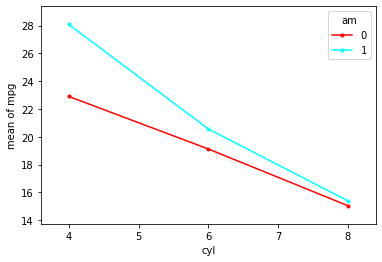

In [28]:
fig = interaction_plot( x = df_mtcars['cyl'],
                        trace = df_mtcars['am'],
                        response = df_mtcars['mpg'] )

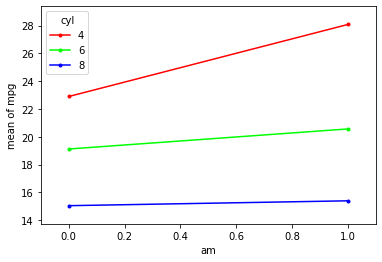

In [29]:
fig = interaction_plot( x = df_mtcars['am'],
                        trace = df_mtcars['cyl'],
                        response = df_mtcars['mpg'] )